In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns


import sys
import functions.token_functions as tf
import spacy
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from collections import defaultdict
import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

In [2]:
nlp = spacy.load('en_core_web_sm')
sw = stopwords.words("english")

In [3]:
# Create an empty list to store the review dataframes
df_list = []
csv_files = os.listdir('../data/games',)

# Iterate over each file in the folder
for file in csv_files:
    # Read the CSV file into a datadrame
    df = pd.read_csv('../data/games/'+file, index_col=0)

    # Append the dataframe to the list
    df_list.append(df)

# Combine the dataframes into a single dataframe
games_df = pd.concat(df_list, ignore_index=True)


In [4]:
# Create an empty list to store the review dataframes
df_list = []
csv_files = os.listdir('../data/books',)

# Iterate over each file in the folder
for file in csv_files:
    # Read the CSV file into a datadrame
    df = pd.read_csv('../data/books/'+file, index_col=0)

    # Append the dataframe to the list
    df_list.append(df)

# Combine the dataframes into a single dataframe
books_df = pd.concat(df_list, ignore_index=True)

In [5]:
# Create an empty list to store the review dataframes
df_list = []
csv_files = os.listdir('../data/movies',)

# Iterate over each file in the folder
for file in csv_files:
    # Read the CSV file into a datadrame
    df = pd.read_csv('../data/movies/'+file, index_col=0)

    # Append the dataframe to the list
    df_list.append(df)

# Combine the dataframes into a single dataframe
movies_df = pd.concat(df_list, ignore_index=True)

In [6]:
movies_df.rename({'movie_title': 'title'}, axis = 1, inplace = True)
books_df.rename({'movie_title': 'title'}, axis = 1, inplace = True)
games_df.rename({'game_title': 'title'}, axis = 1, inplace = True)

In [7]:
all_df = pd.concat([movies_df, books_df, games_df], axis = 0)
all_df.head()

,name,title,review_title,review,rating,date_place
0,Not bad at all,2 Fast 2 Furious,Love this movie,Truly one of my faves. It’s a must watch if yo...,5.0,"Reviewed in the United States 🇺🇸 on May 11, 2023"
1,Coleman,2 Fast 2 Furious,Fast n furious,I LOVE ALL THEIR MOVIES LOL,5.0,"Reviewed in the United States 🇺🇸 on May 16, 2023"
2,Jack Pocock,2 Fast 2 Furious,American Masterpiece,If you didn't enjoy this movie--- you're wrong...,5.0,"Reviewed in the United States 🇺🇸 on April 28, ..."
3,Tina,2 Fast 2 Furious,Satisfied,Kids love these movies,5.0,"Reviewed in the United States 🇺🇸 on April 25, ..."
4,N.Maletich,2 Fast 2 Furious,Classic,Will always live in my heart forever and be on...,5.0,"Reviewed in the United States 🇺🇸 on March 22, ..."


In [8]:
# drop values
all_df = all_df.dropna()

# drop non english reviews
all_df['lang'] = all_df['review'].apply(tf.detect_language)

all_df = all_df.query('lang == "en"')


In [9]:
all_df['review_tokens'] = all_df['review'].apply(tf.clean_tokenize)
all_df['review_title_tokens'] = all_df['review_title'].apply(tf.clean_tokenize)

In [10]:
all_df.groupby(['rating'])['review'].count()

rating
1.0     6478
2.0     3903
3.0     6463
4.0    12777
5.0    91484
Name: review, dtype: int64

In [11]:
all_df['sentiment'] = 0
all_df.loc[all_df['rating']>3, 'sentiment'] = 1
all_df.loc[all_df['rating']<=3, 'sentiment'] = 0

<AxesSubplot:xlabel='sentiment', ylabel='count'>

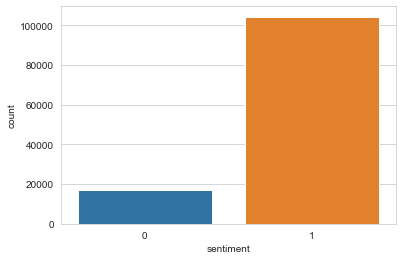

In [12]:
sns.countplot(x=all_df['sentiment'])

## Split Data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(all_df['review'], all_df['sentiment'], test_size=0.20, random_state=10, stratify=all_df['sentiment'])

In [14]:
tf.sentiment_stats(X_train, X_test, y_train, y_test)

Size of Training Data  96884
Size of Test Data  24221
Distribution of classes in Training Data :
Positive Sentiment  86.09161471450393
Negative Sentiment  13.908385285496058
Distribution of classes in Testing Data :
Positive Sentiment  86.09058255233062
Negative Sentiment  13.909417447669378


## Vectorize Data

In [15]:
count = CountVectorizer(min_df = 10, ngram_range=(1,1), stop_words=sw)
X_count_vectors = count.fit_transform(all_df['review'])

idf = TfidfVectorizer(min_df = 10, ngram_range=(1,1), stop_words=sw)
X_tfidf_vectors = idf.fit_transform(all_df['review'])

In [16]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,1), stop_words=sw)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

## Train Sentiment Model

In [17]:
svc_model = LinearSVC(random_state=10, tol=1e-5)
svc_model.fit(X_train_tf, y_train)

LinearSVC(random_state=10, tol=1e-05)

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
y_pred = svc_model.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(y_test, y_pred))
print ('ROC-AUC Score - ', roc_auc_score(y_test, y_pred))

Accuracy Score -  0.9247347343214566
ROC-AUC Score -  0.8017407889619059


## Sample Predictions

In [19]:
sample_reviews = games_df.sample(5)
sample_reviews_tf = tfidf.transform(sample_reviews['review'])
sentiment_predictions = svc_model.predict(sample_reviews_tf)
sentiment_predictions = pd.DataFrame(data = sentiment_predictions,
                                     index=sample_reviews.index,
                                     columns=['sentiment_prediction'])
sample_reviews = pd.concat([sample_reviews, sentiment_predictions], axis=1)
print ('Some sample reviews with their sentiment - ')
sample_reviews[['review','sentiment_prediction']]

Some sample reviews with their sentiment - 


,review,sentiment_prediction
400,You cannot install and launch the game offline...,0
329,Easy to install and the game is a lot of fun,1
912,My son was very happy with this game😊,1
736,The game is horribly broken. They claim it is ...,0
381,amazing game,1


## Pickle Models

In [20]:
with open('../models/svc_model.pkl', 'wb') as file:
    pickle.dump(svc_model, file)

with open('../models/tfidf.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

## Topic Modeling

In [21]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        print(topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [22]:
def topic_to_category(matrix, df):
    topic_to_category = defaultdict(list)
    for idx, row in enumerate(matrix) :
        topic = np.where(row == np.amax(row))[0]
        category = df["sentiment"].iloc[idx]
        sentiment = []
        if category == 1:
            sentiment.append("Positive")
        else:
            sentiment.append("Negative")
        topic_to_category[topic[0]].append(sentiment)  
    return topic_to_category

### NMF

In [23]:
nmf_text_model = NMF(n_components=2, random_state=33)
nmf_text_matrix = nmf_text_model.fit_transform(X_tfidf_vectors)
c_text_matrix = nmf_text_model.components_

C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [24]:
display_topics(nmf_text_model, idf.get_feature_names_out(), 12)


Topic 00
0
  book (2.41)
  read (1.72)
  love (1.20)
  good (0.88)
  one (0.81)
  loved (0.81)
  story (0.65)
  put (0.65)
  books (0.56)
  reading (0.56)
  recommend (0.50)
  really (0.47)

Topic 01
1
  great (27.34)
  movie (12.36)
  book (2.61)
  family (2.18)
  kids (1.71)
  watch (1.52)
  gift (1.06)
  funny (0.91)
  story (0.89)
  condition (0.89)
  read (0.67)
  price (0.62)


### SVD

In [25]:
svd_text_model = TruncatedSVD(n_components=2, random_state=33)
svd_text_matrix = svd_text_model.fit_transform(X_tfidf_vectors)
csvd_text_matrix = svd_text_model.components_

In [26]:
display_topics(svd_text_model, idf.get_feature_names_out(), 12)


Topic 00
0
  book (2.49)
  great (1.82)
  read (1.68)
  love (1.15)
  good (0.84)
  loved (0.79)
  movie (0.76)
  one (0.74)
  story (0.68)
  put (0.60)
  reading (0.52)
  books (0.51)

Topic 01
1
  great (10.08)
  movie (4.81)
  family (0.75)
  watch (0.52)
  kids (0.49)
  gift (0.28)
  funny (0.28)
  condition (0.26)
  price (0.20)
  quality (0.16)
  watched (0.16)
  animation (0.15)


### LDA

In [27]:
lda_text_model = LatentDirichletAllocation(n_components=2, random_state=33)
lda_text_matrix = lda_text_model.fit_transform(X_count_vectors)
clda_text_matrix = lda_text_model.components_

In [28]:
display_topics(lda_text_model, count.get_feature_names_out(), 12)


Topic 00
0
  story (1.61)
  book (1.36)
  love (1.12)
  movie (1.09)
  like (0.90)
  one (0.90)
  characters (0.76)
  loved (0.68)
  good (0.66)
  read (0.61)
  really (0.57)
  would (0.52)

Topic 01
1
  book (7.26)
  read (3.44)
  great (1.40)
  one (1.11)
  reading (0.98)
  books (0.91)
  good (0.87)
  life (0.75)
  love (0.74)
  recommend (0.71)
  put (0.66)
  time (0.53)


In [29]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, X_count_vectors, count, sort_topics=False)

TypeError: drop() takes from 1 to 2 positional arguments but 3 were given

In [ ]:
pyLDAvis.display(lda_display)

In [30]:
with open('../models/lda_model.pkl', 'wb') as file:
    pickle.dump(lda_text_model, file)

with open('../models/count_vect.pkl', 'wb') as file:
    pickle.dump(count, file)